In [3]:
from pathlib import Path

In [4]:
!cat results/**/results.jsonl > results_combined.jsonl
!wc -l results_combined.jsonl

5670 results_combined.jsonl


In [5]:
import pandas as pd
data = pd.read_json("results_combined.jsonl", lines=True)

In [6]:
data.groupby("predictor").count()["id"]

predictor
claude-2         1890
gpt-3.5-turbo    1890
gpt-4            1890
Name: id, dtype: int64

In [25]:
data.keys()

Index(['id', 'fable_id', 'fable1', 'fable2', 'prediction_raw', 'generator1',
       'generator2', 'prediction', 'correct', 'predictor', 'prompt_fun',
       'correct_prediction'],
      dtype='object')

In [7]:
data.dropna().groupby(["predictor", "prediction", "correct_prediction", ])["prediction"].agg(["count"])

count
predictor     prediction correct_prediction       
claude-2      fable1     fable1                104
                         fable2                102
              fable2     fable1                684
                         fable2                721
              unknown    unknown                12
gpt-3.5-turbo fable1     fable1                835
                         fable2                555
              fable2     fable1                110
                         fable2                390
gpt-4         fable1     fable1                210
                         fable2                463
              fable2     fable1                718
                         fable2                479
              none       none                    3
              unknown    unknown                 5

In [38]:
data.dropna().groupby(["predictor", "generator1", "generator2"])["correct"].agg(["mean"])

mean
predictor     generator1    generator2             
claude-2      claude-2      gpt-3.5-turbo  0.027933
                            gpt-4          0.268966
                            human          0.107527
              gpt-3.5-turbo claude-2       0.909091
                            human          0.089947
              gpt-4         claude-2       0.867052
                            human          0.174603
              human         claude-2       0.920792
                            gpt-3.5-turbo  0.904762
                            gpt-4          0.777778
gpt-3.5-turbo claude-2      gpt-3.5-turbo  0.280423
                            human          0.746032
              gpt-3.5-turbo claude-2       0.984127
                            gpt-4          1.000000
                            human          0.994709
              gpt-4         gpt-3.5-turbo  0.624339
                            human          0.693122
              human         claude-2       0.052910
                            gpt-3.5-turbo  0.973545
                            gpt-4          0.132275
gpt-4         claude-2      gpt-4          0.818182
                            human          0.105820
              gpt-3.5-turbo gpt-4          0.259259
                            human          0.142857
              gpt-4         claude-2       0.276243
                            gpt-3.5-turbo  0.090909
                            human          0.507937
              human         claude-2       0.518519
                            gpt-3.5-turbo  0.476190
                            gpt-4          0.470899

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

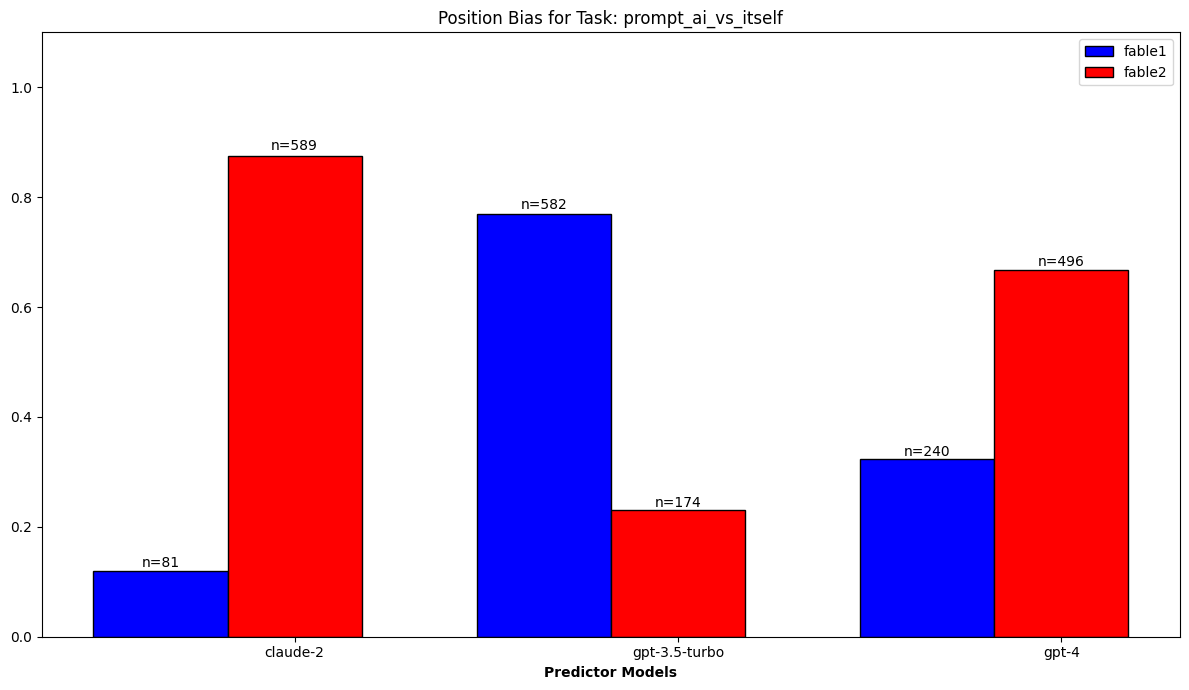

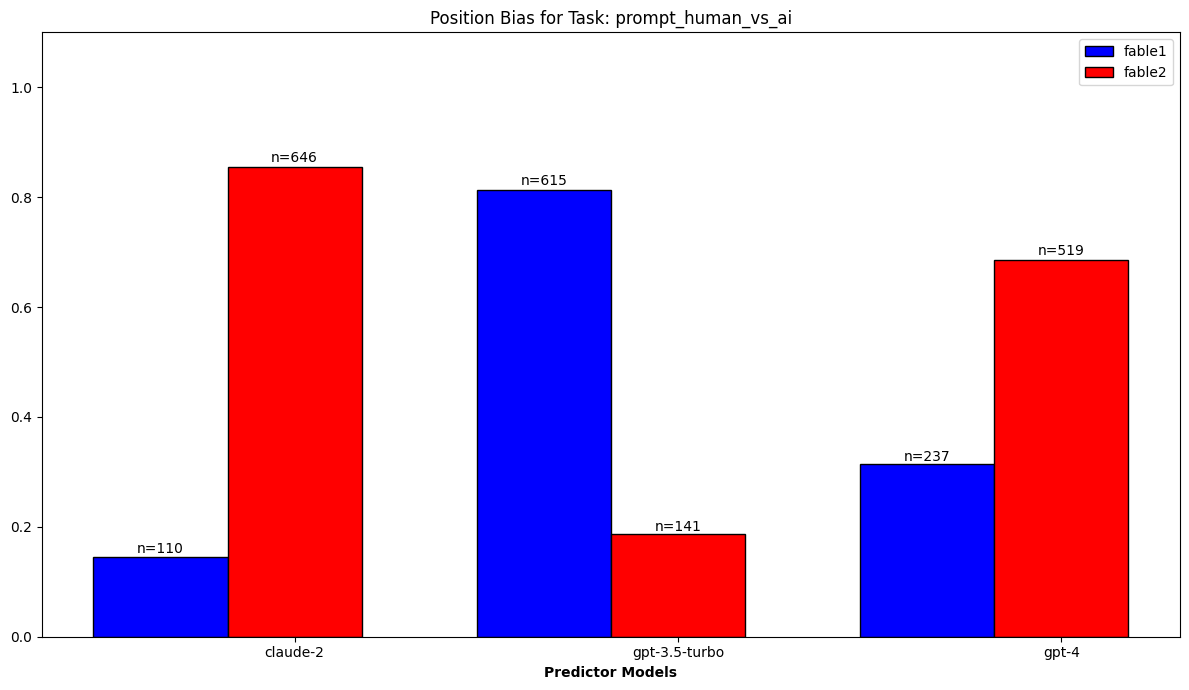

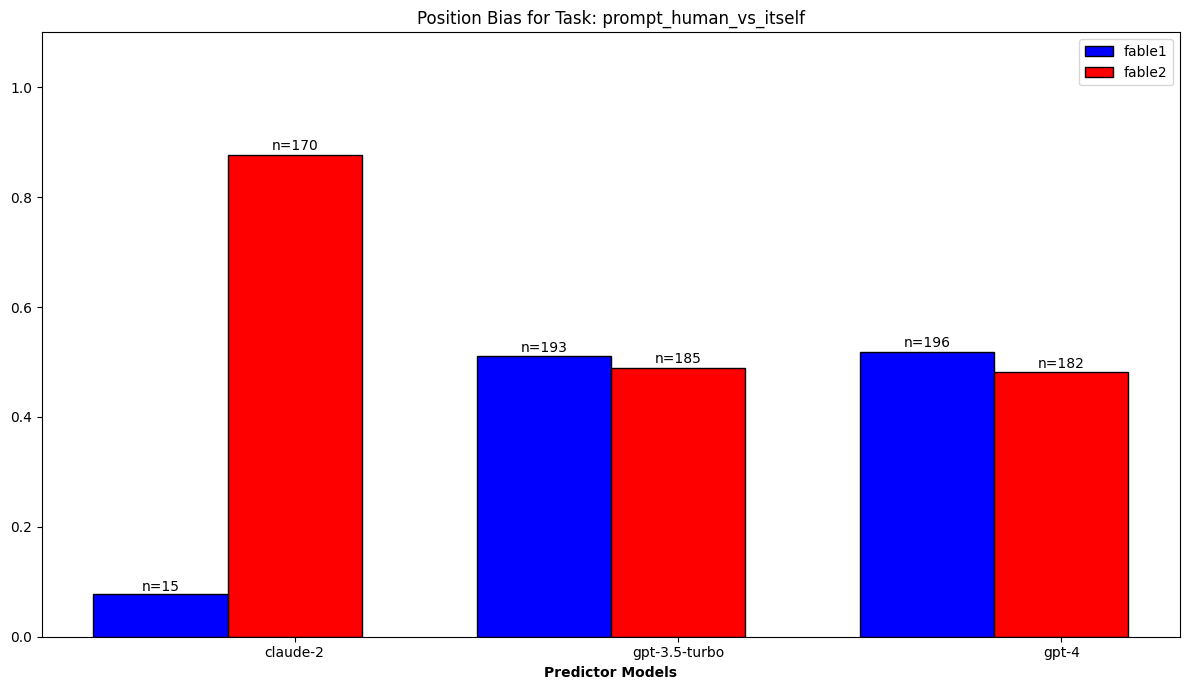

In [63]:

# Compute position bias proportions
position_bias = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts(normalize=True).reset_index(name="proportion")

# Compute the sample sizes
sample_sizes = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts().reset_index(name="count")

# Plotting the position bias
for task in position_bias['prompt_fun'].unique():
    sub_data = position_bias[position_bias['prompt_fun'] == task]
    sub_data_count = sample_sizes[sample_sizes['prompt_fun'] == task]
    
    plt.figure(figsize=(12, 7))
    
    # Setting up the bar positions
    bar_width = 0.35
    r1 = np.arange(len(sub_data['predictor'].unique()))
    r2 = [x + bar_width for x in r1]
    
    # Bars for 'fable1' and 'fable2'
    bars1 = []
    bars2 = []
    counts1 = []
    counts2 = []
    for model in sub_data['predictor'].unique():
        model_data = sub_data[sub_data['predictor'] == model]
        model_data_count = sub_data_count[sub_data_count['predictor'] == model]
        bars1.append(model_data[model_data['prediction'] == 'fable1']['proportion'].values[0] if len(model_data[model_data['prediction'] == 'fable1']) > 0 else 0)
        bars2.append(model_data[model_data['prediction'] == 'fable2']['proportion'].values[0] if len(model_data[model_data['prediction'] == 'fable2']) > 0 else 0)
        counts1.append(model_data_count[model_data_count['prediction'] == 'fable1']['count'].values[0] if len(model_data_count[model_data_count['prediction'] == 'fable1']) > 0 else 0)
        counts2.append(model_data_count[model_data_count['prediction'] == 'fable2']['count'].values[0] if len(model_data_count[model_data_count['prediction'] == 'fable2']) > 0 else 0)
    
    # Create bars
    bar1 = plt.bar(r1, bars1, width=bar_width, label='fable1', color='blue', edgecolor='black')
    bar2 = plt.bar(r2, bars2, width=bar_width, label='fable2', color='red', edgecolor='black')
    
    # Add the counts as labels on top of the bars
    for idx, rect in enumerate(bar1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f'{counts1[idx]}', ha='center', va='bottom')
        
    for idx, rect in enumerate(bar2):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f'{counts2[idx]}', ha='center', va='bottom')
    
    # General layout
    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(bars1))], sub_data['predictor'].unique())
    plt.title(f"Position Bias for Task: {task}")
    plt.ylim(0, 1.1)  # Adjusting y limit to fit counts
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

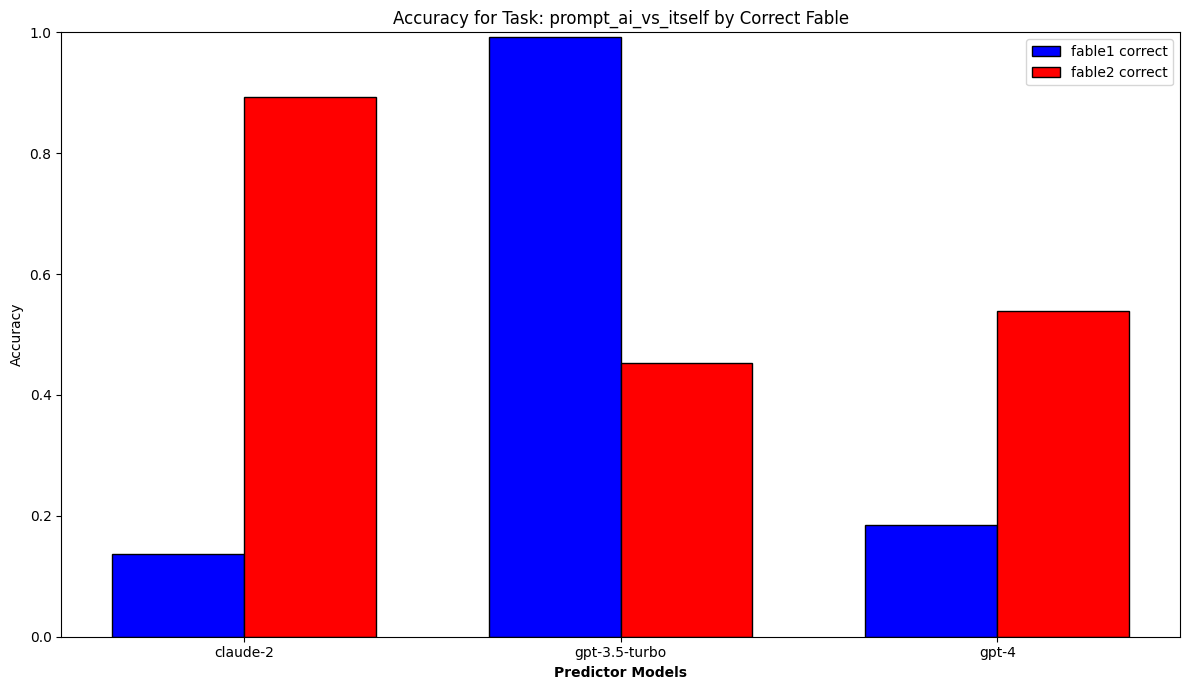

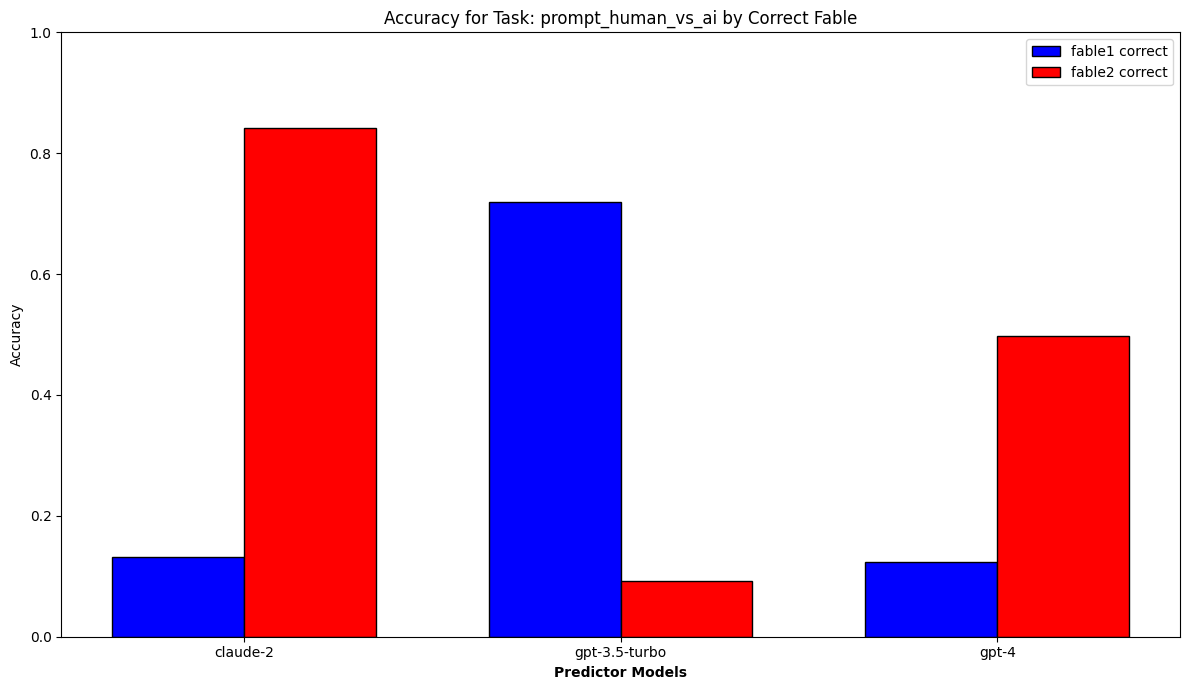

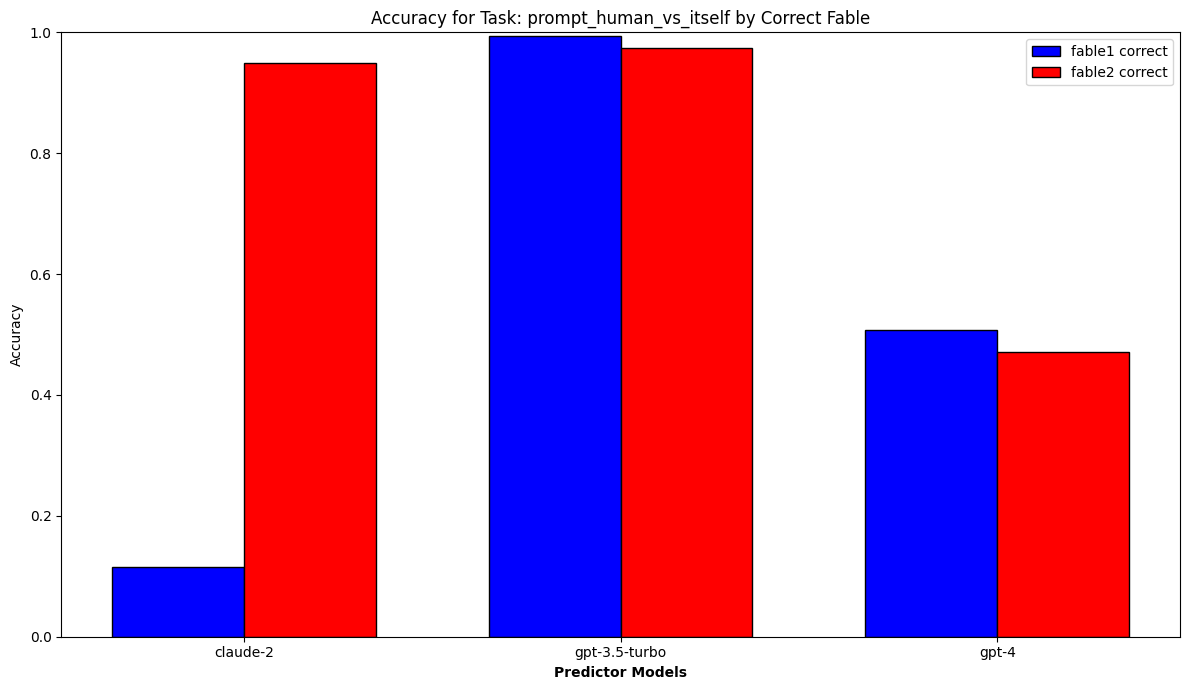

In [53]:
# Calculate accuracy for each condition
accuracy_data = data.groupby(["predictor", "prompt_fun", "correct_prediction"])["correct"].mean().reset_index()

# Plotting the accuracy
for task in accuracy_data['prompt_fun'].unique():
    sub_data = accuracy_data[accuracy_data['prompt_fun'] == task]
    plt.figure(figsize=(12, 7))
    
    # Setting up the bar positions
    bar_width = 0.35
    r1 = np.arange(len(sub_data['predictor'].unique()))
    r2 = [x + bar_width for x in r1]
    
    # Bars for 'fable1' and 'fable2' accuracy
    bars1 = []
    bars2 = []
    for model in sub_data['predictor'].unique():
        model_data = sub_data[sub_data['predictor'] == model]
        bars1.append(model_data[model_data['correct_prediction'] == 'fable1']['correct'].values[0] if len(model_data[model_data['correct_prediction'] == 'fable1']) > 0 else 0)
        bars2.append(model_data[model_data['correct_prediction'] == 'fable2']['correct'].values[0] if len(model_data[model_data['correct_prediction'] == 'fable2']) > 0 else 0)
    
    # Create bars
    plt.bar(r1, bars1, width=bar_width, label='fable1 correct', color='blue', edgecolor='black')
    plt.bar(r2, bars2, width=bar_width, label='fable2 correct', color='red', edgecolor='black')
    
    # General layout
    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(bars1))], sub_data['predictor'].unique())
    plt.title(f"Accuracy for Task: {task} by Correct Fable")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()